# Classifying cell types based on organelle gene expression profiles

A machine learning model was developed to classify cell types based solely on plastid gene expression profiles. This work is part of a larger research study: Using Single-cell RNA Sequencing Data to Study Plastid Differentiation Dynamics with Nucleus-Encoded Gene Expression in *Arabidopsis thaliana*. The high accuracy of this model (>96%) suggests that each cell type houses a distinctive plastid type.

In [19]:
# modules to import 

import os
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt
import math

# Turn off TensorFlow warning messages in program output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [20]:
# Read in data
training_data_df = pd.read_csv("./trnDataND.csv")
validation_data_df = pd.read_csv("./valDataND.csv")
testing_data_df = pd.read_csv("./tstDataND.csv")

In [21]:
Y_train = training_data_df[['ct']].values  # (5256, 1)
Features_train = training_data_df.drop('ct', axis=1).values

Y_validation = validation_data_df[['ct']].values # (1502, 1)
Features_validation = validation_data_df.drop('ct', axis=1).values

Y_test = testing_data_df[['ct']].values  # (751, 1)
Features_test = testing_data_df.drop('ct', axis=1).values

In [22]:
## ===================================
## Example for using one-hot-encoder
## ===================================
values = np.array([['A', 'A', 'B', 'C', 'A', 'B', 'C']]).transpose()
print(values)
print(values.shape)

# help(OneHotEncoder)

# Creat the encoder once
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc.fit(values)

# Use the encoder multiple times
Labels_1 = enc.transform(values)
print(Labels_1)

values2 = np.array([['A', 'A', 'C', 'D']]).transpose() # 2nd set of values
Labels_2 = enc.transform(values2) # transform directly 
print(Labels_2)


[['A']
 ['A']
 ['B']
 ['C']
 ['A']
 ['B']
 ['C']]
(7, 1)
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]


In [24]:
# Use training labels to creat the encoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc.fit(Y_train)

# Use the encoder to transform all labels
Labels_train = enc.transform(Y_train)
print("Train: ", Labels_train.shape)

Labels_validation = enc.transform(Y_validation) # transform directly 
print("Validation: ", Labels_validation.shape)

Labels_test = enc.transform(Y_test) # transform directly
print("Test: ", Labels_test.shape)

print(enc.get_feature_names())  # to get categories in encoding order
print(Y_train[5:10, :])
print(Labels_train[5:10, :])

Train:  (4942, 9)
Validation:  (1412, 9)
Test:  (706, 9)
['x0_Cortex' 'x0_Endodermis' 'x0_Hair Cells' 'x0_Meristem'
 'x0_Non Hair Cells' 'x0_Phloem' 'x0_Root Cap Cells' 'x0_Stele' 'x0_Xylem']
[['Stele']
 ['Non Hair Cells']
 ['Root Cap Cells']
 ['Endodermis']
 ['Hair Cells']]
[[0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [25]:
# Define model parameters

momentum = 0
decay = 0.9
learning_rate = 0.15
training_epochs = 5000
batch_size = 1000
display_step = 1  ## can change that to display less steps
num_examples = Labels_train.shape[0]

# Define how many inputs and outputs are in our neural network
number_of_inputs = Features_train.shape[1]
number_of_outputs = Labels_train.shape[1]

# Define how many neurons we want in each layer of our neural network
layer_1_nodes = number_of_inputs
layer_2_nodes = 400
layer_3_nodes = 100
layer_4_nodes = number_of_outputs*2

In [26]:
## Function to construct a layer --
def layer(input, weight_shape, bias_shape ):
    weight_stddev = (2.0/weight_shape[0])**0.5
    w_init = tf.random_normal_initializer(stddev=weight_stddev)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=w_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    return tf.nn.relu(tf.matmul(input, W) + b)

In [27]:
## Inference: Produce a probability dist over the output classes given a minibatch
def inference(x):
    with tf.variable_scope("hidden_1"):
        hidden_1 = layer(x, [number_of_inputs, layer_1_nodes], [layer_1_nodes])
    with tf.variable_scope("hidden_2"):
        hidden_2 = layer(hidden_1, [layer_1_nodes, layer_2_nodes], [layer_2_nodes])
    with tf.variable_scope("hidden_3"):
        hidden_3 = layer(hidden_2, [layer_2_nodes, layer_3_nodes], [layer_3_nodes])
    with tf.variable_scope("hidden_4"):
        hidden_4 = layer(hidden_3, [layer_3_nodes, layer_4_nodes], [layer_4_nodes])
    with tf.variable_scope("output"):
        output = layer(hidden_4, [layer_4_nodes, number_of_outputs], [number_of_outputs])
    return output

In [28]:
## Get cross-entopy loss given correct labels of a minibatch
def loss(output, y):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y)
    loss = tf.reduce_mean(xentropy)
    return loss

In [29]:
## Training: responsible for computing the gradients of the model parameters
## and updating the model. We use built-in optimizers that produce a training operation
## that we can run via a tf session to minimize model parameters.
def training(cost, global_step):
    tf.summary.scalar("cost", cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    #optimizer = tf.train.RMSPropOptimizer(learning_rate, decay, momentum, epsilon=1e-10, use_locking=False, name='RMSProp')
    #optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op


In [30]:
## Simple computational subgraph to evaluate the model on the validation or test set
def evaluate(output, y):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [31]:
def evaluate_pc(output, y):
    acc, acc_op = tf.metrics.mean_per_class_accuracy(labels=tf.argmax(y, 1), predictions=tf.argmax(output,1), num_classes = number_of_outputs)
    return (acc, acc_op)


In [32]:
def get_conf_mat(output, y):
    conf_mat = tf.confusion_matrix(labels=tf.argmax(y, 1), predictions=tf.argmax(output,1))
    return conf_mat

In [33]:
# meriPlast = pd.read_csv("./meriPlastData.csv")
# meri_test = meriPlast[['ct']].values
# meri_gExp = meriPlast.drop('ct', axis=1).values
# meri_labels = enc.transform(meri_test)
# meri_gExp.shape

In [34]:
# Y_test
# Features_test

meri_test = Y_test[np.where(Y_test[:,0]=="Meristem")][:]
meri_gExp = Features_test[np.where(Y_test[:,0]=="Meristem")][:]
meri_labels = enc.transform(meri_test)
meri_gExp.shape

(108, 1177)

In [35]:
doubPlast = pd.read_csv("./doublets.csv")
doub_test = doubPlast[['ct']].values
doub_gExp = doubPlast.drop('ct', axis=1).values
doub_labels = enc.transform(doub_test)
doub_gExp.shape

(436, 1177)

In [ ]:
accuracies = []
# Run TensorFlow --
with tf.Graph().as_default():
    # Input data with 'number_of_inputs' variables
    x = tf.placeholder("float", [None, number_of_inputs])
    # Output classes
    y = tf.placeholder("float", [None, number_of_outputs])
    output = inference(x)
    cost = loss(output, y)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = training(cost, global_step)
    eval_op = evaluate(output, y)
    evalpc_op = evaluate_pc(output, y)
    get_conf_mat_op = get_conf_mat(output, y)
    
    # Collect all summary statistics that have been logged
    summary_op = tf.summary.merge_all()
    # Save the model parameters using train.Saver() that keeps the latest 5
    # check points, which can be restored for future use
    saver = tf.train.Saver()
    sess = tf.Session()
    
    # write summary statistics to disk
    summary_writer = tf.summary.FileWriter("logs/", graph=sess.graph)
    
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    sess.run(tf.local_variables_initializer())
    
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(num_examples/batch_size)
        # Loop over all batches
        shuffle_vec = np.random.permutation(num_examples)
        Features_train = Features_train[shuffle_vec]
        Labels_train = Labels_train[shuffle_vec]
        for i in range(total_batch):
            mbfrom, mbto = ((i-1)*batch_size, i*batch_size)
            mbatch_x, mbatch_y = (Features_train[mbfrom:mbto, :], Labels_train[mbfrom:mbto, :])
            # Fit training using batch data
            feed_dict = {x: mbatch_x, y: mbatch_y}
            sess.run(train_op, feed_dict=feed_dict)
            # Compute average loss
            minibatch_cost = sess.run(cost, feed_dict=feed_dict)
            avg_cost += minibatch_cost/total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_feed_dict = {x: Features_validation[:,:], y: Labels_validation[:,:]}
            accuracy = sess.run(eval_op, feed_dict=val_feed_dict)
            print("Epoch: ", epoch)
            print("Validation Error:", (1 - accuracy))
            print("Accuracy:", accuracy)
            accuracies.append(accuracy)
            summary_str = sess.run(summary_op, feed_dict=feed_dict)
            summary_writer.add_summary(summary_str, sess.run(global_step))
            saver.save(sess, "logs/model-checkpoint", global_step=global_step)
    print("Optimization Finished!")
    test_feed_dict = {x: Features_test[:,:], y: Labels_test[:,:]}
    accuracy = sess.run(eval_op, feed_dict=test_feed_dict)
    print("Test Accuarcy:", accuracy)
    acc, acc_op = sess.run(evalpc_op, feed_dict=test_feed_dict)
    print([acc, acc_op])
    cm = sess.run(get_conf_mat_op, feed_dict=test_feed_dict)
    print(cm)
    
    test_feed_dict_2 = {x: meri_gExp[:,:], y: meri_labels[:,:]}
    accuracy_2 = sess.run(eval_op, feed_dict=test_feed_dict_2)
    print("Test Accuarcy on Meristematic data:", accuracy_2)
    acc_2, acc_op_2 = sess.run(evalpc_op, feed_dict=test_feed_dict_2)
    print([acc_2, acc_op_2])
    cm_2 = sess.run(get_conf_mat_op, feed_dict=test_feed_dict_2)
    print(cm_2)

    test_feed_dict_3 = {x: doub_gExp[:,:], y: doub_labels[:,:]}
    accuracy_3 = sess.run(eval_op, feed_dict=test_feed_dict_3)
    print("Test Accuarcy on Doublet data:", accuracy_3)
    acc_3, acc_op_3 = sess.run(evalpc_op, feed_dict=test_feed_dict_3)
    print([acc_3, acc_op_3])
    cm_3 = sess.run(get_conf_mat_op, feed_dict=test_feed_dict_3)
    print(cm_3)
    

<IPython.core.display.Javascript object>


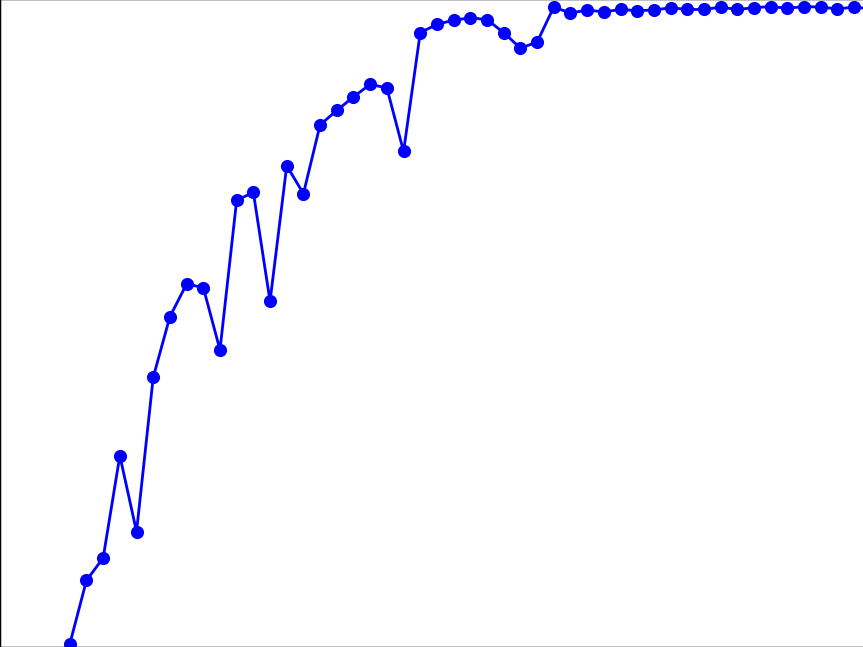

Text(0, 0.5, 'Accuracy')

In [37]:
%matplotlib notebook
x=list(range(1,5001))
y=[i * 100 for i in accuracies]
fig=plt.figure()
# plt.plot(x, y, marker='o', color = 'blue')
ax=fig.add_axes([0,0,1,1])
ax.plot(x, y, '-ok', color = 'blue')
ax.set_title("Accuracy progression through 50 Epochs")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')